In [1]:
import pandas as pd
import datetime

import numpy as np
import warnings

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               StrMethodFormatter,
                               AutoMinorLocator)

In [2]:
data = pd.read_excel('../data/hw_3_2_data.xlsx',sheet_name='macro')
prices = data['CPI']
money = data['M2']

FREQ = 12

# Contemporaneous Regressions

In [3]:
HORZ = FREQ

inflation = (prices / prices.shift(HORZ) -1).dropna()
money_growth = (money/money.shift(HORZ) - 1).dropna()
#money_growth = data.loc[money_growth.index,'Fed']

inflation.name = 'inflation'
money_growth.name = 'money growth'

X = money_growth
y = inflation

results = sm.OLS(y,sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.370
Date:                Tue, 21 Jun 2022   Prob (F-statistic):             0.0118
Time:                        22:38:23   Log-Likelihood:                 1610.0
No. Observations:                 748   AIC:                            -3216.
Df Residuals:                     746   BIC:                            -3207.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0320      0.002     13.839      0.000       0.027       0.037
money growth     0.0729      0.029      2.524      0.012       0.016       0.130
==============================================================================
Omnibus:                      211.421   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.782
Skew:                           1.517   Prob(JB):                    5.38e-106
Kurtosis:                       5.519   Cond. No.                         28.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Lagged (Forecasting) Regressions

## Price Index

Regression result is amazing R-squared.

But is this regression valid?

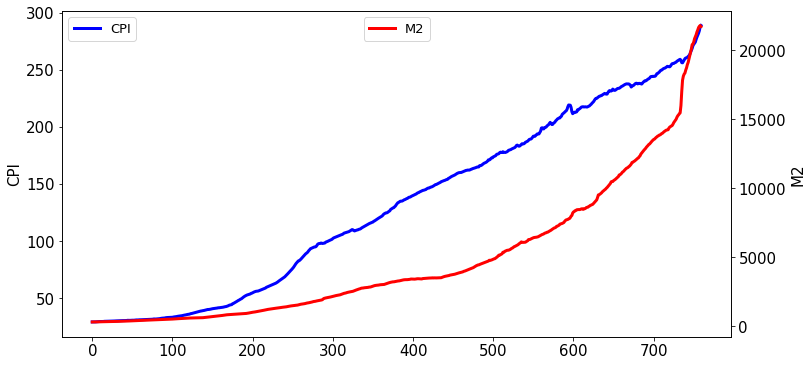

In [4]:
ax = data[['CPI']].plot(color='b',linewidth=3,ylabel='CPI',legend=['CPI'])
ax2 = plt.twinx(ax)
data[['M2']].plot(ax=ax2,color='r',linewidth=3,ylabel='M2',legend=['M2'])
plt.legend(loc='upper center')
plt.show()

In [5]:
def set_autoregressor(df,LAG):
    
    X = df.shift(LAG).dropna()
    y = df

    X,y = X.align(y,join='inner')
    X = X.values.reshape(-1,1)
    y = y.values.reshape(-1,1)

    return X,y

In [6]:
LAG = FREQ

X,y = set_autoregressor(prices,LAG)
mod = LinearRegression().fit(X,y)
mod.score(X,y)

results = sm.OLS(y,sm.add_constant(X)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.960e+05
Date:                Tue, 21 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:38:45   Log-Likelihood:                -1814.0
No. Observations:                 748   AIC:                             3632.
Df Residuals:                     746   BIC:                             3641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1157      0.197     10.714      0.000       1.728       2.503
x1             1.0145      0.001    771.992      0.000       1.012       1.017
==============================================================================
Omnibus:                      264.441   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1607.849
Skew:                           1.460   Prob(JB):                         0.00
Kurtosis:                       9.562   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Stationary Transformation: Growth Rates

* Price Index to Inflation 
* Money to Money Growth

In [7]:
horizons = FREQ * np.array([1,2,3])
if 1 not in horizons:
    horizons = np.insert(horizons,0,1)

r2 = pd.DataFrame(index=pd.Index(horizons,name='horizon (months)'),columns=['inflation','money growth','both'],dtype=float)
betas_uni = r2[['inflation','money growth']].copy()
betas_multi = betas_uni.copy()

for LAG in horizons:

    inflation = (prices / prices.shift(LAG) -1).dropna()
    money_growth = (money/money.shift(LAG) - 1).dropna()
#    money_growth = data.loc[money_growth.index,'Fed']
    inflation.name = 'inflation'
    money_growth.name = 'money growth'
    
    Xi,y = set_autoregressor(inflation,LAG)
    mod = LinearRegression().fit(Xi,y)    
    lab = r2.columns[0]
    r2.loc[LAG,lab] = mod.score(Xi,y)
    betas_uni.loc[LAG,lab] = mod.coef_
    
    Xm,y = set_autoregressor(money_growth,LAG)
    mod = LinearRegression().fit(Xm,y)
    lab = r2.columns[1]
    r2.loc[LAG,lab] = mod.score(Xm,y)
    betas_uni.loc[LAG,lab] = mod.coef_
        
    X = pd.DataFrame(index=inflation.index[LAG:],data=np.concatenate((Xi,Xm),axis=1),columns=['inflation','money growth'])
    y,X = inflation.align(X,join='inner')
    mod = LinearRegression().fit(X,y)
    lab = r2.columns[2]
    r2.loc[LAG,lab] = mod.score(X,y)
    betas_multi.loc[LAG,:] = mod.coef_

In [8]:
display(pd.concat([betas_uni,betas_multi],axis=1,keys=['univariate','multivariate']).style.set_caption('betas').format('{:.1%}'))
display(r2.style.set_caption('r-squared').format('{:.1%}'))

,inflation,money growth,both
horizon (months),,,
1,39.9%,40.2%,40.1%
12,55.5%,17.6%,61.4%
24,40.5%,7.0%,52.3%
36,36.6%,17.7%,54.0%


In [9]:
results = sm.OLS(y,sm.add_constant(X)).fit()

e = results.resid

if len(e.shape)==1:
    e = pd.Series(e)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     402.2
Date:                Tue, 21 Jun 2022   Prob (F-statistic):          2.92e-116
Time:                        22:39:10   Log-Likelihood:                 997.05
No. Observations:                 688   AIC:                            -1988.
Df Residuals:                     685   BIC:                            -1975.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0389      0.007     -5.791      0.000      -0.052      -0.026
inflation        0.4079      0.028     14.555      0.000       0.353       0.463
money growth     0.5043      0.031     16.123      0.000       0.443       0.566
==============================================================================
Omnibus:                       11.287   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               13.418
Skew:                           0.214   Prob(JB):                      0.00122
Kurtosis:                       3.534   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

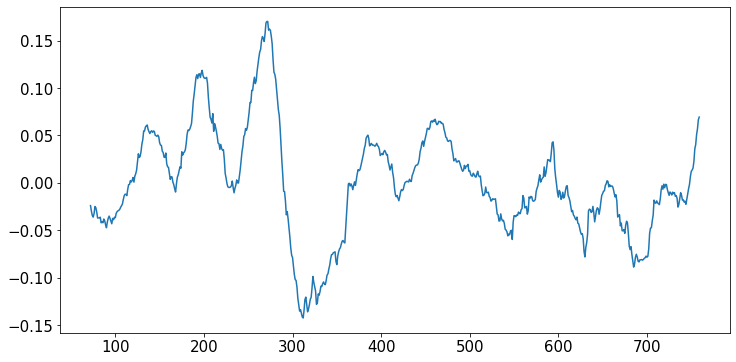

In [10]:
e.plot()
plt.show()